In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import argparse

import tensorflow as tf
from tensorflow.keras import layers, Model

import sklearn.metrics
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../'); sys.path.append('../..')
import utils
from seq2seq_transformer import Encoder, AddPositionalEmbedding
from abstracters import SymbolicAbstracter, RelationalAbstracter
from contextual_decoder import ContextualCrossAttention


seed = 314159

2023-03-08 14:07:37.265072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 14:07:37.549958: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-08 14:07:38.527941: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/loomis/apps/avx/software/cuDNN/8.1.1.33-CUDA-11.2.2/lib:/gpfs/loomis/apps/avx/software/CUDAcore/11.2.2/nvvm/lib64:/gpfs/loomis/apps/avx/software/CUDAcore/11.2.2/extras/CUPTI/lib64:/gpfs/loomis/apps/avx/soft

In [2]:
tf.config.list_physical_devices()

2023-03-08 14:07:44.218394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/loomis/apps/avx/software/cuDNN/8.1.1.33-CUDA-11.2.2/lib:/gpfs/loomis/apps/avx/software/CUDAcore/11.2.2/nvvm/lib64:/gpfs/loomis/apps/avx/software/CUDAcore/11.2.2/extras/CUPTI/lib64:/gpfs/loomis/apps/avx/software/CUDAcore/11.2.2/lib:/vast/palmer/apps/avx.grace/software/Code-Server/4.7.0/lib:/gpfs/loomis/apps/avx/software/Perl/5.32.0-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/DB/18.1.40-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/libreadline/8.0-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/gettext/0.21-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/ncurses/6.2-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/libxml2/2.9.10-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/software/XZ/5.2.5-GCCcore-10.2.0/lib:/gpfs/loomis/apps/avx/softwa

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
import wandb
wandb.login()

import logging
logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)

wandb_project_name = 'dev_abstracter_sorting_generalization'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: awni00. Use `wandb login --relogin` to force relogin


In [4]:
def create_callbacks(monitor='loss'):
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=True),
#         tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'),
        wandb.keras.WandbMetricsLogger(log_freq='epoch'),
        # wandb.keras.WandbModelCheckpoint(filepath='models/model_{epoch:02d}', monitor=monitor, mode='auto', save_freq='epoch')
#         wandb.keras.WandbCallback(
#             monitor=monitor, log_weights=log_weights, log_gradients=log_gradients, save_model=save_model, save_graph=True,
#             training_data=train_ds, validation_data=val_ds,
#             labels=class_names, predictions=64, compute_flops=True)
        ]
    return callbacks

from seq2seq_transformer import TeacherForcingAccuracy
teacher_forcing_acc_metric = TeacherForcingAccuracy(ignore_class=None)
metrics = [teacher_forcing_acc_metric]


loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, ignore_class=None, name='sparse_categorical_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam()

fit_kwargs = {'epochs': 200, 'batch_size': 128}


2023-03-08 14:07:59.299875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset and Utils

In [5]:
# region evaluation code
def evaluate_seq2seq_model(model, source_test, target_test, labels_test, start_token, print_=False):
    
    n = len(source_test)
    output = np.zeros(shape=(n, (seqs_length+1)), dtype=int)
    output[:,0] = start_token
    for i in range(seqs_length):
        predictions = model((source_test, output[:, :-1]), training=False)
        predictions = predictions[:, i, :]
        predicted_id = tf.argmax(predictions, axis=-1)
        output[:,i+1] = predicted_id

    elementwise_acc = (np.mean(output[:,1:] == labels_test))
    acc_per_position = [np.mean(output[:, i+1] == labels_test[:, i]) for i in range(seqs_length)]
    seq_acc = np.mean(np.all(output[:,1:]==labels_test, axis=1))


    teacher_forcing_acc = teacher_forcing_acc_metric(labels_test, model([source_test, target_test]))
    teacher_forcing_acc_metric.reset_state()

    if print_:
        print('element-wise accuracy: %.2f%%' % (100*elementwise_acc))
        print('full sequence accuracy: %.2f%%' % (100*seq_acc))
        print('teacher-forcing accuracy:  %.2f%%' % (100*teacher_forcing_acc))


    return_dict = {
        'elementwise_accuracy': elementwise_acc, 'full_sequence_accuracy': seq_acc,
        'teacher_forcing_accuracy': teacher_forcing_acc, 'acc_by_position': acc_per_position
        }

    return return_dict

def log_to_wandb(model, evaluation_dict):
    acc_by_position_table = wandb.Table(
        data=[(i, acc) for i, acc in enumerate(evaluation_dict['acc_by_position'])], 
        columns=["position", "element-wise accuracy at position"])

    evaluation_dict['acc_by_position'] = wandb.plot.line(
        acc_by_position_table, "position", "element-wise accuracy at position",
        title="Element-wise Accuracy By Position")

    wandb.log(evaluation_dict)

## Task 1: Transformer

In [8]:
task1_data = np.load('object_sorting_datasets/task1_object_sort_dataset.npy', allow_pickle=True).item()

objects, seqs, sorted_seqs, object_seqs, target, labels, start_token = (task1_data['objects'], task1_data['seqs'], task1_data['sorted_seqs'], task1_data['object_seqs'], \
    task1_data['target'], task1_data['labels'], task1_data['start_token'])

test_size = 0.2
val_size = 0.1

seqs_train, seqs_test, sorted_seqs_train, sorted_seqs_test, object_seqs_train, object_seqs_test, target_train, target_test, labels_train, labels_test = train_test_split(
    seqs, sorted_seqs, object_seqs, target, labels, test_size=0.2, random_state=seed)
seqs_train, seqs_val, sorted_seqs_train, sorted_seqs_val, object_seqs_train, object_seqs_val, target_train, target_val, labels_train, labels_val = train_test_split(
    seqs_train, sorted_seqs_train, object_seqs_train, target_train, labels_train, test_size=val_size/(1-test_size), random_state=seed)

seqs_length = seqs.shape[1]

In [9]:
from seq2seq_abstracter_models import Transformer

argsort_model = Transformer(
    num_layers=2, num_heads=2, dff=64, 
    input_vocab='vector', target_vocab=seqs_length+1, output_dim=seqs_length,
    embedding_dim=64)

argsort_model.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
argsort_model((object_seqs_train[:32], target_train[:32]));

argsort_model.summary()

2023-02-26 21:38:39.021916: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_embedder (TimeDistri  multiple                 576       
 buted)                                                          
                                                                 
 target_embedder (Embedding)  multiple                 704       
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  83584     
                                                       

In [33]:
train_size = 5000 # len(seqs_train)
X_train = object_seqs_train[:train_size], target_train[:train_size]
y_train = labels_train[:train_size]

X_val = object_seqs_val, target_val
y_val = labels_val

run = wandb.init(project=wandb_project_name, group='Transformer, Task 1')
history = argsort_model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, callbacks=create_callbacks(), **fit_kwargs)

Epoch 1/200
40/40 [==============================] - 8s 63ms/step - loss: 2.3609 - teacher_forcing_accuracy: 0.1069 - val_loss: 2.2709 - val_teacher_forcing_accuracy: 0.1273
Epoch 2/200
40/40 [==============================] - 2s 39ms/step - loss: 2.2101 - teacher_forcing_accuracy: 0.1545 - val_loss: 2.0030 - val_teacher_forcing_accuracy: 0.2364
Epoch 3/200
40/40 [==============================] - 1s 37ms/step - loss: 1.9475 - teacher_forcing_accuracy: 0.2358 - val_loss: 1.7396 - val_teacher_forcing_accuracy: 0.2806
Epoch 4/200
40/40 [==============================] - 1s 37ms/step - loss: 1.7739 - teacher_forcing_accuracy: 0.2745 - val_loss: 1.6451 - val_teacher_forcing_accuracy: 0.2900
Epoch 5/200
40/40 [==============================] - 1s 37ms/step - loss: 1.6969 - teacher_forcing_accuracy: 0.2840 - val_loss: 1.5867 - val_teacher_forcing_accuracy: 0.2932
Epoch 6/200
40/40 [==============================] - 1s 37ms/step - loss: 1.6401 - teacher_forcing_accuracy: 0.2937 - val_loss: 1.

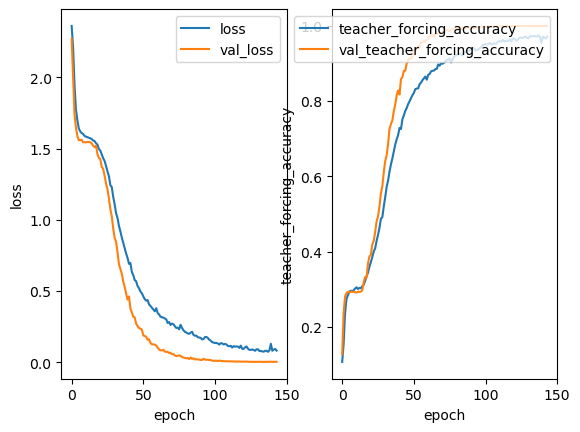

In [34]:
utils.plot_history(history, ('loss', 'teacher_forcing_accuracy'));

In [37]:
eval_dict = evaluate_seq2seq_model(argsort_model, object_seqs_train, target_train, labels_train, 
    start_token=start_token, print_=True)

element-wise accuracy: 99.96%
full sequence accuracy: 99.84%
teacher-forcing accuracy:  99.98%


In [38]:
eval_dict = evaluate_seq2seq_model(argsort_model, object_seqs_test, target_test, labels_test, 
    start_token=start_token, print_=True)
log_to_wandb(argsort_model, eval_dict)
wandb.finish(quiet=True)

element-wise accuracy: 99.95%
full sequence accuracy: 99.80%
teacher-forcing accuracy:  99.98%


## Task 1: Sensory-Connected Abstracter

In [6]:
task1_data = np.load('object_sorting_datasets/task1_object_sort_dataset.npy', allow_pickle=True).item()

objects, seqs, sorted_seqs, object_seqs, target, labels, start_token = (task1_data['objects'], task1_data['seqs'], task1_data['sorted_seqs'], task1_data['object_seqs'], \
    task1_data['target'], task1_data['labels'], task1_data['start_token'])

test_size = 0.2
val_size = 0.1

seqs_train, seqs_test, sorted_seqs_train, sorted_seqs_test, object_seqs_train, object_seqs_test, target_train, target_test, labels_train, labels_test = train_test_split(
    seqs, sorted_seqs, object_seqs, target, labels, test_size=0.2, random_state=seed)
seqs_train, seqs_val, sorted_seqs_train, sorted_seqs_val, object_seqs_train, object_seqs_val, target_train, target_val, labels_train, labels_val = train_test_split(
    seqs_train, sorted_seqs_train, object_seqs_train, target_train, labels_train, test_size=val_size/(1-test_size), random_state=seed)

seqs_length = seqs.shape[1]

: 

: 

In [ ]:
def process_cross_attention_schemes(cross_attention_schemes):
    if isinstance(cross_attention_schemes, list) and all(isinstance(x, dict) for x in cross_attention_schemes):
        for d in cross_attention_schemes:
            if set(d.keys()) != {'key', 'query', 'value'}:
                raise ValueError("dictionaries must have {{'key', 'query', 'value'}} as keys")
            if not all(val in range(-1, len(cross_attention_schemes)) for val in d.values()):
                # checl all values are integer between -1 and the number of sequences
                raise ValueError("values in dictionaries must be the index of one of the input sequences")
        
        return cross_attention_schemes
    elif cross_attention_schemes is None:
        return []
    else:
        raise ValueError("`cross_attention_schmes` must be list of dictionaries")

class MultiAttentionDecoderLayer(tf.keras.layers.Layer):
    """
    A decoder layer with cross-attention from multiple sources.
    """

    def __init__(
        self,
        d_model,
        num_heads,
        dff,
        cross_attention_schemes,
        dropout_rate=0.1,
    ):

        super(MultiAttentionDecoderLayer, self).__init__()

        if causal_self_attention:
            self.causal_self_attention = CausalSelfAttention(
                num_heads=num_heads, key_dim=d_model, dropout=dropout_rate
            )
        
        self.cross_attention_schemes = process_cross_attention_schemes(cross_attention_schemes)

        # create cross-attention layers
        self.cross_attention_layers = [
            ContextualCrossAttention(num_heads=num_heads, key_dim=d_model, dropout_rate=dropout_rate) 
            for _ in range(len(self.cross_attention_schemes))]

        self.ffn = FeedForward(d_model, dff)

    def call(self, input_seq, sequences):

        if len(sequences) != len(self.cross_attention_schemes):
            raise ValueError("unexpected number of `sequences`")

        x = self.causal_self_attention(x=input_seq)

        for cross_attention_layer, cross_attention_scheme in zip(self.cross_attention_layers, self.cross_attention_schemes):
            x = call_cross_attention(cross_attention_layer, cross_attention_scheme, sequences, x)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention_layers[-1].last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.

        return x
    
    def call_cross_attention(cross_attention_layer, cross_attention_scheme, sequences, x):
        key_seq = get_sequence(cross_attention_scheme['key'], sequences, x)
        query_seq = get_sequence(cross_attention_scheme['query'], sequences, x)
        value_seq = get_sequence(cross_attention_scheme['value'], sequences, x)

        x = cross_attention_layer(input_seq=x, query_seq=query_seq, key_seq=key_seq, value_seq=value_seq)

        return x
    
    def get_sequence_from_scheme(scheme, sequences, x):
        # return `x`` if cross-attention scheme asks for -1, else return index in `sequences``
        return x if scheme==-1 else sequences[scheme]

class MultiAttentionDecoder(tf.keras.layers.Layer):
    """A generalized decoder with configurable cross-attention schemes"""

    def __init__(
        self,
        num_layers,
        num_heads,
        dff,
        cross_attention_schemes,
        dropout_rate=0.1,
        name="decoder",
    ):

        super(ContextDecoder, self).__init__(name=name)

        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dff = dff
        self.cross_attention_schemes = cross_attention_schemes
        self.dropout_rate = dropout_rate

    def build(self, input_shape):

        _, self.sequence_length, self.d_model = input_shape

        self.dropout = tf.keras.layers.Dropout(self.dropout_rate)

        self.dec_layers = [
            MultiAttentionDecoderLayer(
                d_model=self.d_model,
                num_heads=self.num_heads,
                dff=self.dff,
                cross_attention_schemes=self.cross_attention_schemes,
                dropout_rate=self.dropout_rate
            )
            for _ in range(self.num_layers)
        ]

        self.last_attn_scores = None

    def call(self, input_seq, sequences):

        x = self.dropout(input_seq)

        for i in range(self.num_layers):
            x = self.dec_layers[i](input_seq=x, sequences=sequences)

        #             self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        return x

In [ ]:
class Seq2SeqMultiAttentionSensoryConnectedAbstracter(tf.keras.Model):
    def __init__(self, num_layers, num_heads, dff,
            input_vocab, target_vocab, embedding_dim, output_dim, 
            cross_attention_schemes=None,
            dropout_rate=0.1, name='seq2seq_sensory_connected_abstracter'):
        super().__init__(name=name)

        if isinstance(input_vocab, int):
            self.source_embedder = layers.Embedding(input_vocab, embedding_dim, name='source_embedder')
        elif input_vocab == 'vector':
            self.source_embedder = layers.TimeDistributed(layers.Dense(embedding_dim), name='source_embedder')
        else:
            raise ValueError(
                "`input_vocab` must be an integer if the input sequence is token-valued or "
                "'vector' if the input sequence is vector-valued.")

        if isinstance(target_vocab, int):
            self.target_embedder = layers.Embedding(target_vocab, embedding_dim, name='target_embedder')
        elif input_vocab == 'vector':
            self.source_embedder = layers.TimeDistributed(layers.Dense(embedding_dim), name='target_embedder')
        else:
            raise ValueError(
                "`input_vocab` must be an integer if the input sequence is token-valued or "
                "'vector' if the input sequence is vector-valued.")

        self.pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
        self.pos_embedding_adder_target = AddPositionalEmbedding(name='add_pos_embedding_target')
    
        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
        self.abstracter = RelationalAbstracter(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='abstracter')
        
        if cross_attention_schemes is None:
            self.cross_attention_schemes = [
                {'key': -1, 'query': 0, 'value': 0}, # cross-attention scheme for encoder-decoder
                {'key': 1, 'query': 1, 'value': -1} # cross-attention scheme for abstracter-decoder
                ]
        else:
            self.cross_attention_schemes = process_cross_attention_schemes(cross_attention_schemes)
            if len(cross_attention_schemes) != 2: raise ValueError("must be 2 cross-attention schemes")
    
        self.decoder = MultiAttentionDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff, cross_attention_schmes=cross_attention_schemes,
          dropout_rate=dropout_rate, name='decoder')
        self.final_layer = layers.Dense(output_dim, name='final_layer')


    def call(self, inputs):
        source, target  = inputs

        x = self.source_embedder(source)
        x = self.pos_embedding_adder_input(x)

        encoder_context = self.encoder(x)

        abstracted_context = self.abstracter(encoder_context)

        target_embedding = self.target_embedder(target)
        target_embedding = self.pos_embedding_adder_target(target_embedding)

        x = self.decoder(input_seq=target_embedding, sequences=[encoder_context, abstracted_context])

        # Final linear layer output.
        logits = self.final_layer(x)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass

        return logits

In [20]:
cross_attention_schemes = [
    {'key': -1, 'query': 0, 'value': 0}, # cross-attention scheme for encoder-decoder
    {'key': 1, 'query': 1, 'value': -1} # cross-attention scheme for abstracter-decoder
    ]

argsort_model = Seq2SeqMultiAttentionSensoryConnectedAbstracter(
    num_layers=2, num_heads=2, dff=64, 
    input_vocab='vector', target_vocab=seqs_length+1, output_dim=seqs_length,
    embedding_dim=64, cross_attention_schemes=cross_attention_schemes)

argsort_model.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
argsort_model((object_seqs_train[:32], target_train[:32]));

argsort_model.summary()

NameError: name 'AddPositionalEmbedding' is not defined

In [13]:
train_size = 5000 # len(seqs_train)
X_train = object_seqs_train[:train_size], target_train[:train_size]
y_train = labels_train[:train_size]

X_val = object_seqs_val, target_val
y_val = labels_val

run = wandb.init(project=wandb_project_name, group='Sensory-Connected Abstracter, Task 1')
history = argsort_model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, callbacks=create_callbacks(), **fit_kwargs)

Epoch 1/200
40/40 [==============================] - 9s 83ms/step - loss: 2.3758 - teacher_forcing_accuracy: 0.1092 - val_loss: 2.2706 - val_teacher_forcing_accuracy: 0.1291
Epoch 2/200
40/40 [==============================] - 2s 50ms/step - loss: 2.2192 - teacher_forcing_accuracy: 0.1521 - val_loss: 1.9987 - val_teacher_forcing_accuracy: 0.2425
Epoch 3/200
40/40 [==============================] - 2s 51ms/step - loss: 1.9301 - teacher_forcing_accuracy: 0.2501 - val_loss: 1.6855 - val_teacher_forcing_accuracy: 0.3197
Epoch 4/200
40/40 [==============================] - 2s 51ms/step - loss: 1.7219 - teacher_forcing_accuracy: 0.3131 - val_loss: 1.5328 - val_teacher_forcing_accuracy: 0.3658
Epoch 5/200
40/40 [==============================] - 2s 50ms/step - loss: 1.5867 - teacher_forcing_accuracy: 0.3540 - val_loss: 1.4496 - val_teacher_forcing_accuracy: 0.3950
Epoch 6/200
40/40 [==============================] - 2s 52ms/step - loss: 1.5124 - teacher_forcing_accuracy: 0.3855 - val_loss: 1.

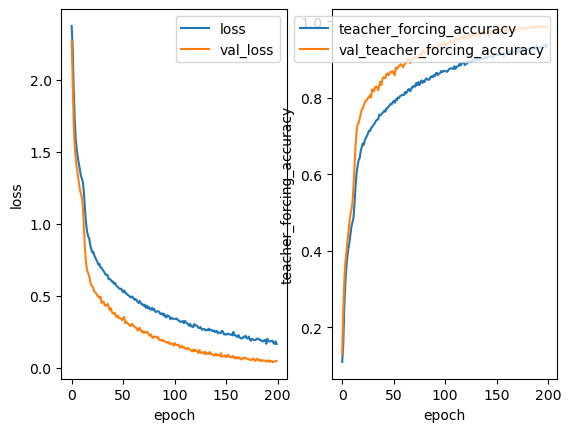

In [14]:
utils.plot_history(history, ('loss', 'teacher_forcing_accuracy'));

In [15]:
eval_dict = evaluate_seq2seq_model(argsort_model, object_seqs_train, target_train, labels_train, 
    start_token=start_token, print_=True)

element-wise accuracy: 96.96%
full sequence accuracy: 86.53%
teacher-forcing accuracy:  98.55%


In [16]:
eval_dict = evaluate_seq2seq_model(argsort_model, object_seqs_test, target_test, labels_test, 
    start_token=start_token, print_=True)
log_to_wandb(argsort_model, eval_dict)
wandb.finish(quiet=True)

element-wise accuracy: 96.74%
full sequence accuracy: 85.62%
teacher-forcing accuracy:  98.46%


## Task 2: Training Seq2Seq Sensory-Connected Abstracter with Frozen Abstracter Module

In [8]:
task1_data = np.load('object_sorting_datasets/task1_object_sort_dataset.npy', allow_pickle=True).item()

objects, seqs, sorted_seqs, object_seqs, target, labels, start_token = (task1_data['objects'], task1_data['seqs'], task1_data['sorted_seqs'], task1_data['object_seqs'], \
    task1_data['target'], task1_data['labels'], task1_data['start_token'])

test_size = 0.2
val_size = 0.1

seqs_train, seqs_test, sorted_seqs_train, sorted_seqs_test, object_seqs_train, object_seqs_test, target_train, target_test, labels_train, labels_test = train_test_split(
    seqs, sorted_seqs, object_seqs, target, labels, test_size=0.2, random_state=seed)
seqs_train, seqs_val, sorted_seqs_train, sorted_seqs_val, object_seqs_train, object_seqs_val, target_train, target_val, labels_train, labels_val = train_test_split(
    seqs_train, sorted_seqs_train, object_seqs_train, target_train, labels_train, test_size=val_size/(1-test_size), random_state=seed)

seqs_length = seqs.shape[1]

In [9]:
from seq2seq_abstracter_models import Seq2SeqSensoryConnectedAbstracter

argsort_model2 = Seq2SeqSensoryConnectedAbstracter(
    num_layers=2, num_heads=2, dff=64, 
    input_vocab='vector', target_vocab=seqs_length+1, output_dim=seqs_length,
    embedding_dim=64)

argsort_model2.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
argsort_model2((object_seqs_train[:32], target_train[:32]));

argsort_model2.summary()

Model: "seq2seq_sensory_connected_abstracter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_embedder (TimeDistri  multiple                 576       
 buted)                                                          
                                                                 
 target_embedder (Embedding)  multiple                 704       
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  83584     
                              

In [17]:
print(dir(argsort_model.abstracter.abstracter_layers[0].episodic_attention))

['_TF_MODULE_IGNORED_PROPERTIES', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_activity_regularizer', '_add_trackable', '_add_trackable_child', '_add_variable_with_custom_getter', '_auto_track_sub_layers', '_autocast', '_autographed_call', '_build_input_shape', '_call_spec', '_callable_losses', '_captured_weight_regularizer', '_cast_single_input', '_checkpoint_dependencies', '_clear_losses', '_compute_dtype', '_compute_dtype_object', '_dedup_weights', '_deferred_dependencies', '_delete_tracking', '_deserialization_dependencies', '_deserialize_from_proto', '_dtype', '_dtype_policy', '_dynamic', '_eager_losses', '_expects_mask_arg', '_expects_traini

In [30]:
[weight.name for weight in argsort_model.abstracter.abstracter_layers[0].episodic_attention.mha.weights]

['seq2seq_sensory_connected_abstracter/abstracter/relational_abstracter_layer/relational_attention/multi_head_attention_3/query/kernel:0',
 'seq2seq_sensory_connected_abstracter/abstracter/relational_abstracter_layer/relational_attention/multi_head_attention_3/query/bias:0',
 'seq2seq_sensory_connected_abstracter/abstracter/relational_abstracter_layer/relational_attention/multi_head_attention_3/key/kernel:0',
 'seq2seq_sensory_connected_abstracter/abstracter/relational_abstracter_layer/relational_attention/multi_head_attention_3/key/bias:0',
 'seq2seq_sensory_connected_abstracter/abstracter/relational_abstracter_layer/relational_attention/multi_head_attention_3/value/kernel:0',
 'seq2seq_sensory_connected_abstracter/abstracter/relational_abstracter_layer/relational_attention/multi_head_attention_3/value/bias:0',
 'seq2seq_sensory_connected_abstracter/abstracter/relational_abstracter_layer/relational_attention/multi_head_attention_3/attention_output/kernel:0',
 'seq2seq_sensory_connecte

In [41]:
print(dir(argsort_model.abstracter.abstracter_layers[0].episodic_attention.mha.weights[0]))

['SaveSliceInfo', '_OverloadAllOperators', '_OverloadOperator', '_TensorConversionFunction', '__abs__', '__add__', '__and__', '__array__', '__array_priority__', '__bool__', '__class__', '__complex__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__div__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__idiv__', '__imul__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ipow__', '__irealdiv__', '__isub__', '__iter__', '__itruediv__', '__le__', '__long__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pow__', '__radd__', '__rand__', '__rdiv__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rmatmul__', '__rmod__', '__rmul__', '__ror__', '__rpow__', '__rsub__', '__rtruediv__', '__rxor__', '__setattr__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__tf_trac

In [49]:
# NOTE / TODO: for now, freezing ALL params of abstracter
# prolly need to unfreeze weights associated with values coming from encoder / decoder...
argsort_model2.abstracter.set_weights(argsort_model.abstracter.weights)
argsort_model2.abstracter.trainable = False
print(len(argsort_model2.trainable_variables))

# make variables associated with sensory-side in cross-attention trainable
for abstracter_layer in argsort_model2.abstracter.abstracter_layers:
    for i, weight in enumerate(abstracter_layer.episodic_attention.mha.weights):
        if ('key' in weight.name) or ('query' in weight.name):
            abstracter_layer.episodic_attention.mha.weights[i] = tf.Variable(weight.value, trainable=True)

print(len(argsort_model2.trainable_variables))
argsort_model2.summary()

89
89
Model: "seq2seq_sensory_connected_abstracter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_embedder (TimeDistri  multiple                 576       
 buted)                                                          
                                                                 
 target_embedder (Embedding)  multiple                 704       
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  83584     
                        

In [16]:
train_size = 5000 # len(seqs_train)
X_train = object_seqs_train[:train_size], target_train[:train_size]
y_train = labels_train[:train_size]

# X_val = seqs_val, target_val
X_val = object_seqs_val, target_val
y_val = labels_val

run = wandb.init(project=wandb_project_name, name=f'TASK 2 (Pre-Trained Abstracter)')
history = argsort_model2.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, callbacks=create_callbacks(), **fit_kwargs)

Epoch 1/50
40/40 [==============================] - 11s 108ms/step - loss: 3.3998 - teacher_forcing_accuracy: 0.9385 - val_loss: 2.2345 - val_teacher_forcing_accuracy: 0.1921
Epoch 2/50
40/40 [==============================] - 3s 66ms/step - loss: 2.2700 - teacher_forcing_accuracy: 0.1481 - val_loss: 2.1333 - val_teacher_forcing_accuracy: 0.2150
Epoch 3/50
40/40 [==============================] - 3s 66ms/step - loss: 2.1538 - teacher_forcing_accuracy: 0.1925 - val_loss: 1.9823 - val_teacher_forcing_accuracy: 0.2552
Epoch 4/50
40/40 [==============================] - 3s 67ms/step - loss: 2.0265 - teacher_forcing_accuracy: 0.2342 - val_loss: 1.8182 - val_teacher_forcing_accuracy: 0.2978
Epoch 5/50
40/40 [==============================] - 3s 66ms/step - loss: 1.8843 - teacher_forcing_accuracy: 0.2785 - val_loss: 1.6172 - val_teacher_forcing_accuracy: 0.3586
Epoch 6/50
40/40 [==============================] - 3s 66ms/step - loss: 1.7330 - teacher_forcing_accuracy: 0.3219 - val_loss: 1.4605

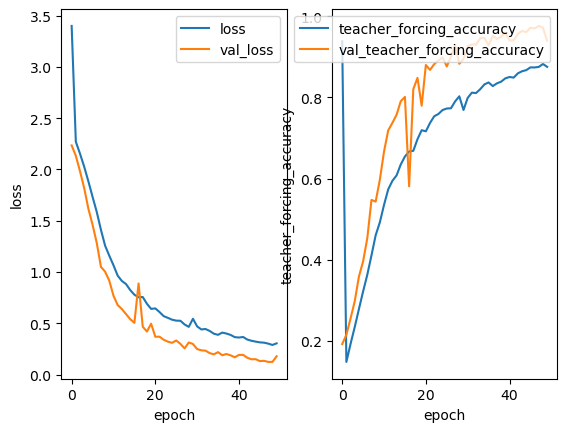

In [17]:
utils.plot_history(history, ('loss', 'teacher_forcing_accuracy'));

In [18]:
eval_dict = evaluate_seq2seq_model(argsort_model2, object_seqs_train, target_train, labels_train,
    start_token=START_TOKEN, print_=True)

element-wise accuracy: 93.95%
full sequence accuracy: 58.06%
teacher-forcing accuracy:  93.99%


In [19]:
eval_dict = evaluate_seq2seq_model(argsort_model2, object_seqs_test, target_test, labels_test, 
    start_token=START_TOKEN, print_=True)
log_to_wandb(argsort_model2, eval_dict)
wandb.finish(quiet=True)

element-wise accuracy: 93.87%
full sequence accuracy: 57.84%
teacher-forcing accuracy:  93.98%


## Transformer: Training Seq2Seq Sensory-Connected Abstracter

In [15]:
# dataset 1
vocab_size = 64
dim = 8
seqs_length = 10
START_TOKEN = seqs_length
n_seqs = 10_0000

objects, seqs, sorted_seqs, arg_sort, object_seqs = create_sorting_dataset(vocab_size, dim, seqs_length, n_seqs)

target = arg_sort[:, :-1]
labels = arg_sort[:, 1:]

test_size = 0.2
val_size = 0.1

seqs_train, seqs_test, sorted_seqs_train, sorted_seqs_test, object_seqs_train, object_seqs_test, target_train, target_test, labels_train, labels_test = train_test_split(
    seqs, sorted_seqs, object_seqs, target, labels, test_size=0.2)
seqs_train, seqs_val, sorted_seqs_train, sorted_seqs_val, object_seqs_train, object_seqs_val, target_train, target_val, labels_train, labels_val = train_test_split(
    seqs_train, sorted_seqs_train, object_seqs_train, target_train, labels_train, test_size=val_size/(1-test_size))

In [16]:
from tensorflow.keras import layers
from seq2seq_transformer import Encoder, AddPositionalEmbedding
from contextual_decoder import ContextualCrossAttention, ContextDecoderLayer, ContextDecoder
from abstracters import RelationalAbstracter

class ArgsortTransformer(tf.keras.Model):
    def __init__(self, num_layers, num_heads, dff,
            input_vocab_size, target_vocab_size, embedding_dim,
            dropout_rate=0.1, name='argsort_transformer'):
        super().__init__(name=name)

        self.source_embedder = layers.TimeDistributed(layers.Dense(embedding_dim), name='source_embedder')
        self.target_embedder = layers.Embedding(target_vocab_size, embedding_dim, name='target_embedder')

        self.pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
        self.pos_embedding_adder_target = AddPositionalEmbedding(name='add_pos_embedding_target')

        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
        self.decoder = ContextDecoder(num_layers=num_layers, num_heads=num_heads, dff=dff,
          dropout_rate=dropout_rate, name='decoder')

        self.final_layer = layers.Dense(target_vocab_size, name='final_layer')


    def call(self, inputs):
        source, target  = inputs

        x = self.source_embedder(source)
        x = self.pos_embedding_adder_input(x)

        encoder_context = self.encoder(x)

        target_embedding = self.target_embedder(target)
        target_embedding = self.pos_embedding_adder_target(target_embedding)

        x = self.decoder(input_seq=target_embedding, query_seq=target_embedding, key_seq=encoder_context, value_seq=encoder_context)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass

        # Return the final output and the attention weights.
        return logits


In [17]:
argsort_model = ArgsortTransformer(
    num_layers=2, num_heads=2, dff=64, 
    input_vocab_size=vocab_size, target_vocab_size=seqs_length+1, embedding_dim=64)

argsort_model.compile(loss=loss, optimizer=create_opt(), metrics=metrics)
argsort_model((object_seqs_train[:32], target_train[:32]));

argsort_model.summary()

Model: "argsort_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_embedder (TimeDistri  multiple                 576       
 buted)                                                          
                                                                 
 target_embedder (Embedding)  multiple                 704       
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 add_pos_embedding_target (A  multiple                 0         
 ddPositionalEmbedding)                                          
                                                                 
 encoder (Encoder)           multiple                  83584     
                                               

In [26]:
train_size = 5000 # len(seqs_train)
X_train = object_seqs_train[:train_size], target_train[:train_size]
y_train = labels_train[:train_size]

X_val = object_seqs_val, target_val
y_val = labels_val

run = wandb.init(project=wandb_project_name, name=f'Transformer (standard final layer)')
history = argsort_model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, callbacks=create_callbacks(), **fit_kwargs)

Epoch 1/50
40/40 [==============================] - 2s 49ms/step - loss: 0.3140 - teacher_forcing_accuracy: 0.8818 - val_loss: 0.1099 - val_teacher_forcing_accuracy: 0.9627
Epoch 2/50
40/40 [==============================] - 2s 44ms/step - loss: 0.3013 - teacher_forcing_accuracy: 0.8866 - val_loss: 0.1008 - val_teacher_forcing_accuracy: 0.9658
Epoch 3/50
40/40 [==============================] - 2s 44ms/step - loss: 0.2943 - teacher_forcing_accuracy: 0.8899 - val_loss: 0.1059 - val_teacher_forcing_accuracy: 0.9635
Epoch 4/50
40/40 [==============================] - 2s 44ms/step - loss: 0.2972 - teacher_forcing_accuracy: 0.8901 - val_loss: 0.0983 - val_teacher_forcing_accuracy: 0.9664
Epoch 5/50
40/40 [==============================] - 2s 44ms/step - loss: 0.2969 - teacher_forcing_accuracy: 0.8878 - val_loss: 0.0875 - val_teacher_forcing_accuracy: 0.9722
Epoch 6/50
40/40 [==============================] - 2s 44ms/step - loss: 0.2960 - teacher_forcing_accuracy: 0.8894 - val_loss: 0.0985 -

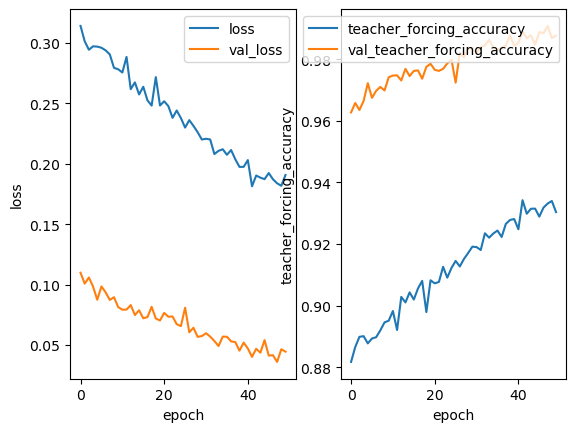

In [27]:
utils.plot_history(history, ('loss', 'teacher_forcing_accuracy'));

In [28]:
eval_dict = evaluate_seq2seq_model(argsort_model, object_seqs_train, target_train, labels_train, 
    start_token=START_TOKEN, print_=True)

element-wise accuracy: 97.34%
full sequence accuracy: 87.96%
teacher-forcing accuracy:  98.72%


In [29]:
eval_dict = evaluate_seq2seq_model(argsort_model, object_seqs_test, target_test, labels_test, 
    start_token=START_TOKEN, print_=True)
log_to_wandb(argsort_model, eval_dict)
wandb.finish(quiet=True)

element-wise accuracy: 97.25%
full sequence accuracy: 87.53%
teacher-forcing accuracy:  98.66%
